In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

titanic_df = pd.read_csv('./titanic/titanic_train.csv')
y = titanic_df["Survived"]
feature_name = titanic_df.columns
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [29]:
def fillna(df):
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean') #missing_values=np.nan 모든 결측값을 대체한다. / strategy='mean' 평균으로 대체한다.
    age_array = df['Age'].to_numpy().reshape(-1, 1)
    imputer.fit(age_array)
    df['Age'] = imputer.transform(age_array)
    return df


def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    print(df.head(3), "\n\n")

    df = df.drop('Survived', axis=1, inplace=False)
    return df


# 레이블
def encode_features_label(df):
    features = ['Cabin', 'Sex', 'Embarked']
    le = LabelEncoder()
    for feature in features:
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df



# 표준화 => 2차원 데이터
def stscaler(df):
    features = ['Age', 'Fare']
    sc = StandardScaler()
    for feature in features:
        df[[feature]] = sc.fit_transform(df[[feature]])
    return df
    

# # 원핫
# # one-hot 인코딩을 하면 많은 0 값을 포함하기 때문에, 이러한 데이터를 희소 행렬 형식으로 저장하면 메모리 사용량을 크게 줄일 수 있다.
# # ColumnTransformer는 인코딩된 데이터를 OneHotEncoder를 통해 처리한 후에 희소 행렬 형태로 반환
# def encode_features_onehot(df):
#     ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 6, 7])], remainder='passthrough')
#     df = ct.fit_transform(df)
#     # df = pd.DataFrame(df.toarray()) # 희소 행렬을 Dense 형태로 변환 후 DataFrame으로 변환
#     return df


titanic_df = fillna(titanic_df)
titanic_df = drop_features(titanic_df)

titanic_df = stscaler(titanic_df)

# titanic_df = encode_features_onehot(titanic_df)
titanic_df = encode_features_label(titanic_df)
print(titanic_df[:3])

X_train, X_test, y_train, y_test = train_test_split(titanic_df, y, test_size=0.2)

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
0         0       3    male  22.0      1      0   7.2500     N        S
1         1       1  female  38.0      1      0  71.2833   C85        C
2         1       3  female  26.0      0      0   7.9250     N        S 


   Pclass  Sex       Age  SibSp  Parch      Fare  Cabin  Embarked
0       3    1 -0.592481      1      0 -0.502445    146         3
1       1    0  0.638789      1      0  0.786845     81         0
2       3    0 -0.284663      0      0 -0.488854    146         3


In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# 개별 모델은 로지스틱 회귀와 KNN,  
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier(random_state=42)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf, dt]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.8324
LogisticRegression 정확도: 0.8156
KNeighborsClassifier 정확도: 0.7374
DecisionTreeClassifier 정확도: 0.7989


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy), "\n")

# GridSearchCV
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# y_train = y_train.values.flatten()

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

랜덤 포레스트 정확도: 0.8547 

최적 하이퍼 파라미터:
 {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 16}
최고 예측 정확도: 0.8301


In [32]:
rf_clf1 = RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=8, n_estimators=30, n_jobs=-1)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

print(f"train 정확도: {rf_clf1.score(X_train, y_train)}")
print(f"test 정확도: {rf_clf1.score(X_test, y_test)}")

예측 정확도: 0.7933
train 정확도: 0.8356741573033708
test 정확도: 0.7932960893854749


In [35]:
ftr_importances_values = rf_clf1.feature_importances_

ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)

ftr_importances.sort_values(ascending=False)

Sex         0.399571
Pclass      0.160021
Fare        0.137170
Cabin       0.100978
Age         0.095147
SibSp       0.038559
Embarked    0.037917
Parch       0.030637
dtype: float64

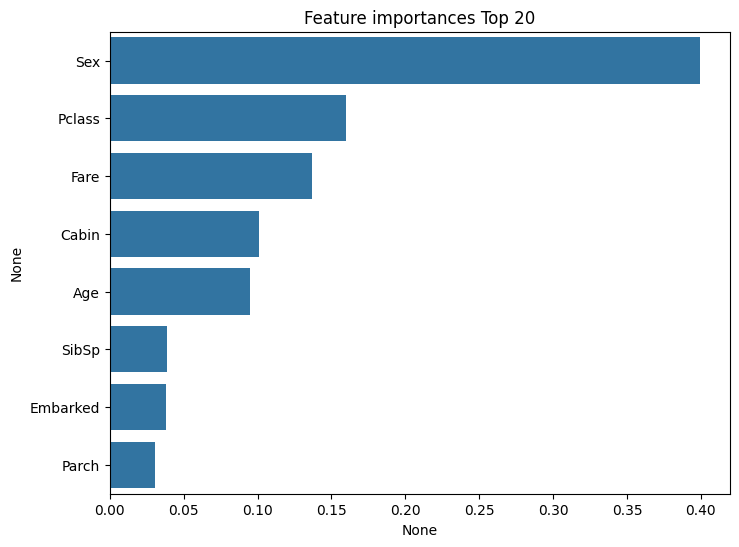

In [34]:
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [36]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    
    accuracy = accuracy_score(y_test , pred)
    
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    
    f1 = f1_score(y_test,pred)
    
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion, "\n")
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc), "\n")


In [37]:
# VotingClassifier 학습/예측/평가. 
# vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt)], voting='soft')
pred_vo = vo_clf.predict(X_test)
pred_proba_vo = vo_clf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print(f"test 정확도: {vo_clf.score(X_test, y_test)}")

get_clf_eval(y_test , pred_vo, pred_proba_vo)
print("\n\n")


# VotingClassifier에 RandomForestClassifier 추가
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)
dt = DecisionTreeClassifier(random_state=42)
rf_clf2 = RandomForestClassifier()
# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf), ('KNN',knn_clf), ('DT', dt), ('RF', rf_clf2)], voting='soft')

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred_vo2 = vo_clf.predict(X_test)
pred_proba_vo2 = vo_clf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print(f"test 정확도: {vo_clf.score(X_test, y_test)}", "\n")

get_clf_eval(y_test , pred_vo2, pred_proba_vo2)

Voting 분류기 정확도: 0.7933
test 정확도: 0.8324022346368715
오차 행렬
[[103   9]
 [ 21  46]] 

정확도: 0.8324, 정밀도: 0.8364, 재현율: 0.6866,    F1: 0.7541, AUC:0.8478 




Voting 분류기 정확도: 0.7933
test 정확도: 0.8212290502793296 

오차 행렬
[[100  12]
 [ 20  47]] 

정확도: 0.8212, 정밀도: 0.7966, 재현율: 0.7015,    F1: 0.7460, AUC:0.8563 



In [50]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)

gb_pred = gb_clf.predict(X_test)
print(gb_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(gb_accuracy)
print("\n")

pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1] # 분류 결정 예측 확률

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time), "\n\n")

print(f"GBM - train: {gb_clf.score(X_train, y_train)}")
print(f"GBM - test: {gb_clf.score(X_test, y_test)}")


get_clf_eval(y_test , gb_pred, pred_proba_gb)

[0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1
 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0
 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0]
0.8379888268156425


GBM 정확도: 0.8380
GBM 수행 시간: 0.1 초  


GBM - train: 0.9115168539325843
GBM - test: 0.8379888268156425
오차 행렬
[[100  12]
 [ 17  50]] 

정확도: 0.8380, 정밀도: 0.8065, 재현율: 0.7463,    F1: 0.7752, AUC:0.8582 



In [39]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
최고 예측 정확도: 0.8174


In [40]:
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.8380
